# QRAO with JijModelingTranspiler

In [1]:
import numpy as np
import networkx as nx
import qiskit as qk
import matplotlib.pyplot as plt
import jijmodeling as jm
import jijmodeling.transpiler as jmt
import jijtranspiler_qiskit as jtq

## QRAO for MaxCut
With `transpiler_qiskit`, you can convert not only to Ising Hamiltonian, but also to QRAO HAmiltonian.
In this note, we will actually convert to QRAO Hamiltonian and perform a VQE.
This Algorithm is based on Fuller et al.(2021)

In [2]:
def maxcut_problem():
    # define variables
    E = jm.Placeholder('E',dim = 2)
    N = jm.Placeholder('N')
    x = jm.Binary('x', shape=N)
    e = jm.Element('e', E).set_latex('(i,j)')
    s_i = 1 - 2*x[e[0]]
    s_j = 1 - 2*x[e[1]]
    s_i.set_latex('s_i') 
    s_j.set_latex('s_j') 
    
    # set problem
    problem = jm.Problem('MAXCUT')
    problem += -1/2 * jm.Sum(e,1 - s_i*s_j)
    return problem

problem = maxcut_problem()
problem

/tmp/ipykernel_162890/1490413976.py:3: JijFutureWarning: The argument `dim` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `ndim` instead.
  E = jm.Placeholder('E',dim = 2)
/tmp/ipykernel_162890/1490413976.py:5: JijFutureWarning: The class `Binary` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `BinaryVar` instead.
  x = jm.Binary('x', shape=N)
/tmp/ipykernel_162890/1490413976.py:6: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  e = jm.Element('e', E).set_latex('(i,j)')
/tmp/ipykernel_162890/1490413976.py:14: JijFutureWarning: The function `Sum` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `sum` instead.
  problem += -1/2 * jm.Sum(e,1 - s_i*s_j)


Here we want to solve a 20-node 3regular graph as an example.

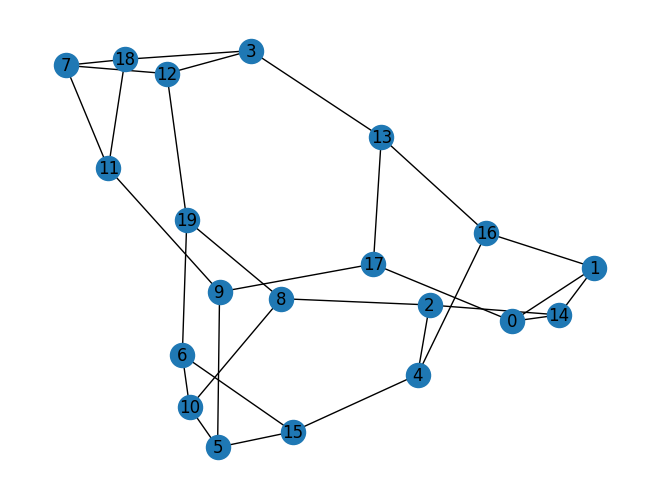

In [3]:
num_nodes = 20
G = nx.random_regular_graph(3, num_nodes)
nx.draw(G, with_labels=True)
instance_data = {'E': [list(edge) for edge in G.edges], 'N': num_nodes}

### Transpile to QRAO Hamiltonian
Transpiling to the QRAC Hamiltonian can be done in much the same way as transpiling to the Ising Hamiltonian.

In [4]:
compiled_instance = jmt.core.compile_model(problem, instance_data)

qrac_builder = jtq.qrao.transpile_to_qrac31_hamiltonian(compiled_instance, normalize=False)

qrac_hamiltonian, offset, encoding_cache = qrac_builder.get_hamiltonian()

<frozen jijmodeling.transpiler.core.substitute.element_convert>:47: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.


In [5]:
num_qubit = len(encoding_cache.color_group)
print(f"compression ration : {num_qubit / num_nodes}")

compression ration : 0.4


In [6]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator, Sampler
from scipy.optimize import minimize

In [7]:
ansatz = RealAmplitudes(num_qubit, reps=1)

def cost_func(parameters, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=parameters).result().values[0]
    return cost

In [8]:
initial_params = np.random.uniform(0, 2 * np.pi, ansatz.num_parameters)
estimator = Estimator()
optimization_history = []
qrac_result = minimize(cost_func, initial_params, args=(ansatz, qrac_hamiltonian, estimator), method='BFGS',callback = lambda x:optimization_history.append(cost_func(x,ansatz, qrac_hamiltonian, estimator)))

Now we also obtain the VQE results.
Due to the small size of the problem, we can also calculate the exact solution.
Here, we also compute the exact solution for the Ising Hamiltonian to compare the results.

In [9]:
from qiskit.algorithms.eigensolvers import NumPyEigensolver
from jijtranspiler_qiskit.qaoa import to_ising_operator_from_qubo

In [10]:
qaoa_builder = jtq.qaoa.transpile_to_qaoa_ansatz(compiled_instance, normalize=False)
ising_hamiltonian,ising_const = qaoa_builder.get_hamiltonian()

eigen_solver = NumPyEigensolver()
result = eigen_solver.compute_eigenvalues(ising_hamiltonian)
ising_optimal = -(np.array(result.eigenvalues) + ising_const)[0].real

In [11]:
eigen_solver = NumPyEigensolver()
result = eigen_solver.compute_eigenvalues(qrac_hamiltonian)
qrac_optimal = -(result.eigenvalues + offset )[0].real

The obtained results are plotted. Indeed, we can see that there is a finite gap between the original Ising Hamiltonian and the maximum eigenvalue of the QRAO Hamiltonian.

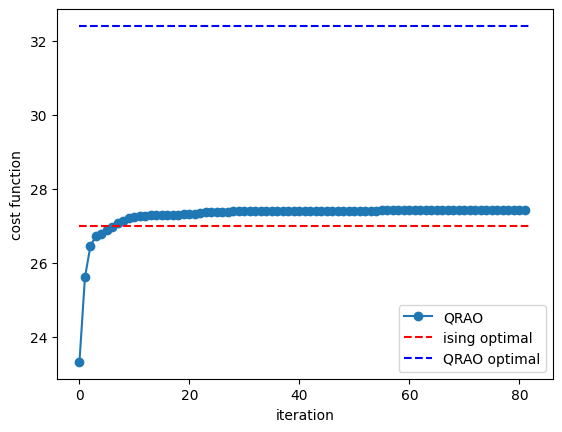

In [12]:
plt.plot(-(np.array(optimization_history) + offset),"o-", label='QRAO')
plt.plot([0, len(optimization_history)],[ising_optimal ,ising_optimal ], "red", linestyle='dashed',label = "ising optimal")
plt.plot([0, len(optimization_history)],[qrac_optimal , qrac_optimal], "blue", linestyle='dashed',label = "QRAO optimal")
plt.xlabel('iteration')
plt.ylabel('cost function')
plt.legend()

In [13]:
def pauli_rounding(ansatz,qrac_result, encoding_cache):
    encoded_op = encoding_cache.encoding
    n_qubit = len(encoding_cache.color_group)
    sorted_op = sorted(encoded_op.items())

    variable_ops = [jtq.qrao.qrao31.create_pauli_term([pauli_kind], [color], n_qubit) for idx,(color,pauli_kind) in sorted_op]

    num_variables = len(variable_ops)
    estimator = Estimator()
    estimator_result = estimator.run([ansatz] * num_variables, variable_ops, parameter_values=[qrac_result.x] * num_variables)
    
    rng = np.random.default_rng()
    def sign(val) -> int:
        return 1 if (val > 0) else 0
    rounded_vars = [sign(e) if not np.isclose(0, e) else rng.choice([0,1]) for e in estimator_result.result().values]
    return rounded_vars

In [14]:
rounding_result = pauli_rounding(ansatz,qrac_result, encoding_cache)

In [15]:
sampleset = qrac_builder.decode_from_binary_values([rounding_result])
sampleset

SampleSet(record=Record(solution={'x': [(([6, 10, 4, 3, 7, 8, 17, 11, 14, 1],), [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (20,))]}, num_occurrences=[[1]]), evaluation=Evaluation(energy=None, objective=[-22.0], constraint_violations={}, penalty={}), measuring_time=MeasuringTime(solve=SolvingTime(preprocess=None, solve=None, postprocess=None), system=SystemTime(post_problem_and_instance_data=None, request_queue=None, fetch_problem_and_instance_data=None, fetch_result=None, deserialize_solution=None), total=None))

# Calculate gap size
The next step is to examine the change in gap width.

In [16]:
def maxcut_problem():
    # define variables
    E = jm.Placeholder('E',dim = 2)
    N = jm.Placeholder('N')
    x = jm.Binary('x', shape=N)
    e = jm.Element('e', E).set_latex('(i,j)')
    s_i = 1 - 2*x[e[0]]
    s_j = 1 - 2*x[e[1]]
    s_i.set_latex('s_i') 
    s_j.set_latex('s_j') 
    
    # set problem
    problem = jm.Problem('MAXCUT')
    problem += -1/2 * jm.Sum(e,1 - s_i*s_j)
    return problem

In [17]:
def calculate_qrac_optimal(compiled_model, multipliers={}):
    qrac_builder = jtq.qrao.transpile_to_qrac31_hamiltonian(compiled_model, normalize=False)
    qrac_hamiltonian, offset, encoding_cache = qrac_builder.get_hamiltonian(multipliers=multipliers)
    
    eigen_solver = NumPyEigensolver()
    result = eigen_solver.compute_eigenvalues(qrac_hamiltonian)
    return (np.array(result.eigenvalues) + offset )[0].real

def calculate_ising_optimal(compiled_model, multipliers={}):
    qaoa_builder = jtq.qaoa.transpile_to_qaoa_ansatz(compiled_model, normalize=False)
    ising_hamiltonian,offset = qaoa_builder.get_hamiltonian(multipliers=multipliers)

    eigen_solver = NumPyEigensolver()
    result = eigen_solver.compute_eigenvalues(ising_hamiltonian)

    return (np.array(result.eigenvalues) + offset)[0].real

def calculate_gap_size(problem,instance_data,multipliers={}):
    compiled_model = jmt.core.compile_model(problem,instance_data)
    qrao_optimal = calculate_qrac_optimal(compiled_model, multipliers=multipliers)
    ising_optimal = calculate_ising_optimal(compiled_model, multipliers=multipliers)
    return np.abs(qrao_optimal - ising_optimal), qrao_optimal, ising_optimal


In [18]:
problem = maxcut_problem()
problem

/tmp/ipykernel_162890/2603548978.py:3: JijFutureWarning: The argument `dim` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `ndim` instead.
  E = jm.Placeholder('E',dim = 2)
/tmp/ipykernel_162890/2603548978.py:5: JijFutureWarning: The class `Binary` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `BinaryVar` instead.
  x = jm.Binary('x', shape=N)
/tmp/ipykernel_162890/2603548978.py:6: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  e = jm.Element('e', E).set_latex('(i,j)')
/tmp/ipykernel_162890/2603548978.py:14: JijFutureWarning: The function `Sum` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `sum` instead.
  problem += -1/2 * jm.Sum(e,1 - s_i*s_j)


In [19]:
bound_sizes = []
qrao_optimals = []
ising_optimals = []
for num_nodes in range(4,24,2):
    G = nx.random_regular_graph(3, num_nodes)
    instance_data = {'E': [list(edge) for edge in G.edges], 'N': num_nodes}
    gap_size,qrao_optimal,ising_optimal =  calculate_gap_size(problem,instance_data)
    bound_sizes.append(gap_size)
    qrao_optimals.append(-qrao_optimal)
    ising_optimals.append(-ising_optimal)

<frozen jijmodeling.transpiler.core.substitute.element_convert>:47: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.


The gap size increase with increasing the numbder of nodes.

Text(0.5, 0, 'number of nodes')

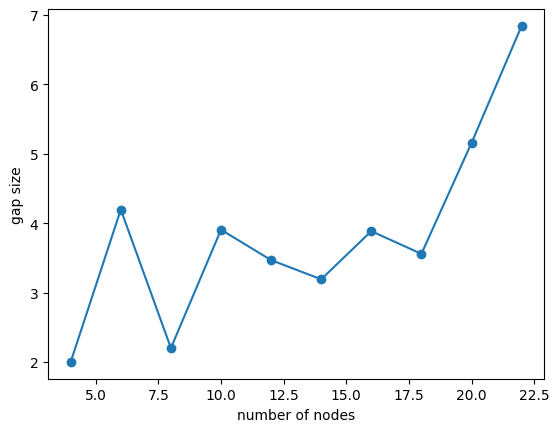

In [20]:
plt.plot(range(4,24,2),bound_sizes,"o-")
plt.ylabel("gap size")
plt.xlabel("number of nodes")

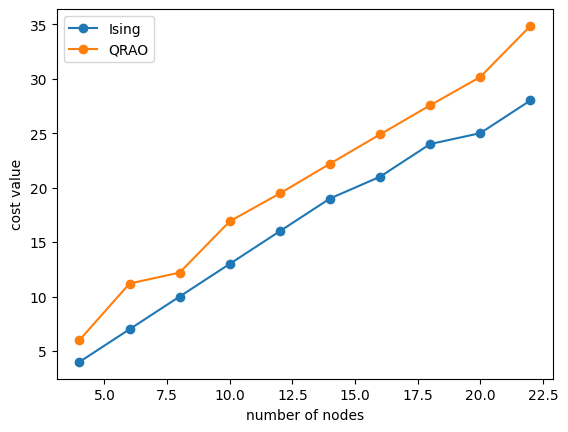

In [21]:
plt.plot(range(4,24,2),ising_optimals,"o-",label = "Ising")
plt.plot(range(4,24,2),qrao_optimals,"o-",label = "QRAO")
plt.ylabel("cost value")
plt.xlabel("number of nodes")
plt.legend()

Next, we look at a constrained problem, the graph partition problem.

In [22]:
def graph_partition():
    # define variables
    V = jm.Placeholder('V')
    E = jm.Placeholder('E', dim=2)
    x = jm.Binary('x', shape=(V))
    u = jm.Element('u', V)
    e = jm.Element('e', E)# set problem
    problem = jm.Problem('Graph Partitioning')
    # set constraint: the vertices must be partitioined into two equal-sized sets
    const = jm.Sum(u, x[u])
    problem += jm.Constraint('constraint', const==V/2)
    # set objective function: minimize the number of edges crossing the partition
    A_1 = x[e[0]]*(1-x[e[1]])
    A_2 = (1-x[e[0]])*x[e[1]]
    problem += jm.Sum(e, (A_1 + A_2))
    return problem

In [38]:
problem = graph_partition()
problem

/tmp/ipykernel_162890/2149500668.py:4: JijFutureWarning: The argument `dim` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `ndim` instead.
  E = jm.Placeholder('E', dim=2)
/tmp/ipykernel_162890/2149500668.py:5: JijFutureWarning: The class `Binary` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `BinaryVar` instead.
  x = jm.Binary('x', shape=(V))
/tmp/ipykernel_162890/2149500668.py:6: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  u = jm.Element('u', V)
/tmp/ipykernel_162890/2149500668.py:7: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  e = jm.Element('e', E)# set problem
/tmp/ipykernel_162890/2149500668.py:10: JijFutureWarning: The function `Sum` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `sum` instead.
  const = jm

In [39]:
results = {}
for penalty_value in [1,2,5,10]:
    bound_sizes = []
    qrao_optimals = []
    ising_optimals = []
    for num_nodes in range(4,18,2):
        G = nx.gnp_random_graph(num_nodes, 0.4)
        # print(f" A = {min(2 * max(dict(G.degree).values()),num_nodes)/8}")
        instance_data = {'E': [list(edge) for edge in G.edges], 'V': num_nodes}
        gap_size,qrao_optimal,ising_optimal =  calculate_gap_size(problem,instance_data,multipliers={'constraint':penalty_value})
        bound_sizes.append(gap_size)
        qrao_optimals.append(qrao_optimal)
        ising_optimals.append(ising_optimal)
        results[penalty_value] = (bound_sizes,qrao_optimals,ising_optimals)
        

<frozen jijmodeling.transpiler.core.substitute.element_convert>:47: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `with_penalty` is deprecated. It will be removed when updating to jijmodeling 1.x.x.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `with_multiplier` is deprecated. It will be removed when updating to jijmodeling 1.x.x.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `auto_qubo` is deprecated. It will be removed when updating to jijmodeling 1.x.x.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `label` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `name` instead.
<frozen jijmodeling.tra

It can be seen that the Gap width largely depends on the value of the penalty coefficient.

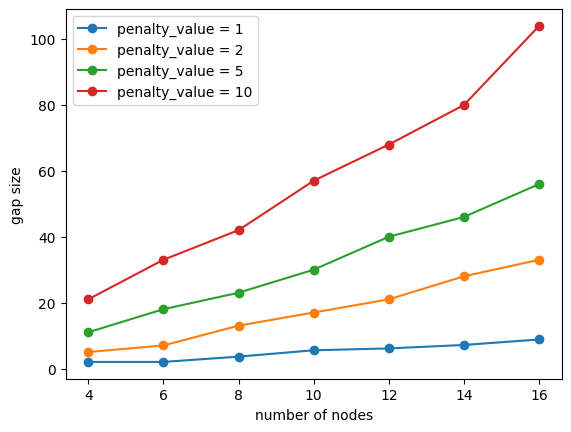

In [40]:
for key,value in results.items():
    plt.plot(range(4,18,2),np.abs(value[0]),"o-",label = f"penalty_value = {key}")
plt.ylabel("gap size")
plt.xlabel("number of nodes")
plt.legend()

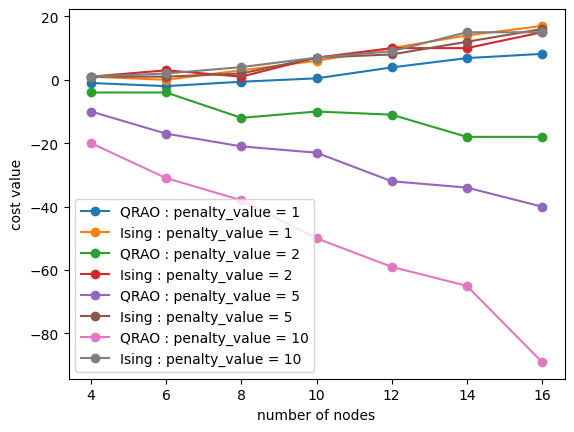

In [41]:
for key,value in results.items():
    plt.plot(range(4,18,2),value[1],"o-",label = f"QRAO : penalty_value = {key}")
    plt.plot(range(4,18,2),value[2],"o-",label = f"Ising : penalty_value = {key}")
plt.ylabel("cost value")
plt.xlabel("number of nodes")
plt.legend()

In [50]:
def vqe_and_rounding(problem,instance_data):
    compiled_instance = jmt.core.compile_model(problem, instance_data)
    qrac_builder = jtq.qrao.transpile_to_qrac31_hamiltonian(compiled_instance, normalize=False)
    qrac_hamiltonian, offset, encoding_cache = qrac_builder.get_hamiltonian()
    ansatz = RealAmplitudes(len(encoding_cache.color_group), reps=1)

    def cost_func(parameters, ansatz, hamiltonian, estimator):
        cost = estimator.run(ansatz, hamiltonian, parameter_values=parameters).result().values[0]
        return cost
    
    initial_params = np.random.uniform(0, 2 * np.pi, ansatz.num_parameters)
    estimator = Estimator()
    optimization_history = []
    qrac_result = minimize(cost_func, initial_params, args=(ansatz, qrac_hamiltonian, estimator), method='BFGS',callback = lambda x:optimization_history.append(cost_func(x,ansatz, qrac_hamiltonian, estimator)))
    rounding_result = pauli_rounding(ansatz,qrac_result, encoding_cache)
    sampleset = qrac_builder.decode_from_binary_values([rounding_result])
    return sampleset, optimization_history, qrac_result

In [52]:
_results = {}
for penalty_value in [1,2,5,10]:
    G = nx.gnp_random_graph(10, 0.4)
    # print(f" A = {min(2 * max(dict(G.degree).values()),num_nodes)/8}")
    instance_data = {'E': [list(edge) for edge in G.edges], 'V': num_nodes}
    gap_size,qrao_optimal,ising_optimal =  calculate_gap_size(problem,instance_data,multipliers={'constraint':penalty_value})
    
    sampleset, optimization_history, qrac_result = vqe_and_rounding(problem,instance_data)
    _results[penalty_value] = (sampleset,qrac_result,gap_size,qrao_optimal,ising_optimal)

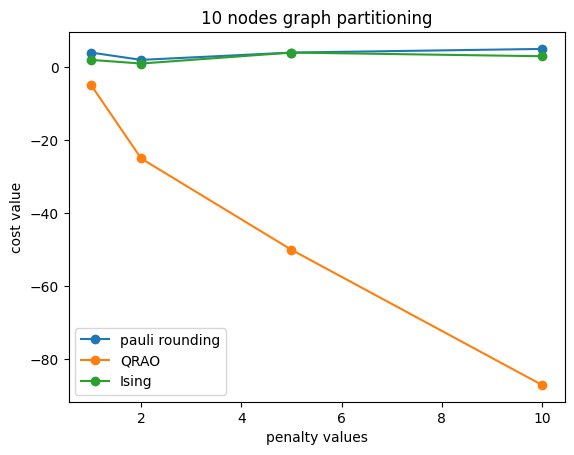

In [54]:
penalty_values = [key for key in _results.keys()]
pauli_rounding_results = [value[0].evaluation.objective[-1] for value in _results.values()]
qrao_optimals = [value[3] for value in _results.values()]
ising_optimals = [value[4] for value in _results.values()]
plt.plot(penalty_values,pauli_rounding_results,"o-",label = "pauli rounding")
plt.plot(penalty_values,qrao_optimals,"o-",label = "QRAO")
plt.plot(penalty_values,ising_optimals,"o-",label = "Ising")
plt.title("10 nodes graph partitioning")
plt.ylabel("cost value")
plt.xlabel("penalty values")
plt.legend()